# Baseline Model

The goal of this notebook is to develop a scrappy baseline model which we can improve on later if we decide to implement an LSTM or otherwise. But beforehand, we need to process the data and determine what input features to use for the ANN.

## Pre-processing
1. Construct the feature/target set. 
2. Scale the data
3. Split train/test

In [1]:
import pandas as pd
import sys
import os
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
sys.path.insert(0, os.path.abspath('../')) 

from lib.common import constants as k
from lib.eirgrid import data as eirgrid_data
from lib.common.marginal_emissions import compute_mef
from lib.common.data_window import DataWindow

# Eirgrid system
eirgrid = eirgrid_data.system()
eirgrid = compute_mef(eirgrid).dropna()

There are some instances where the MEF is infinite.
This is because $\Delta PG_{i,t+1} = 0$ meaning there was no change in generation

The simplest thing to do is backfillt this with the MEF of the previous time step. 
The assumption being if there was no change in generation, the MEF should remain the same.

In [2]:
print('There are %d inf MEF values' % eirgrid['MarginalEmissions'].isin([np.inf, -np.inf]).sum())
eirgrid = eirgrid.replace([np.inf, -np.inf], np.nan)
eirgrid = eirgrid.ffill()
print('There are %d inf MEF values' % eirgrid['MarginalEmissions'].isin([np.inf, -np.inf]).sum())

There are 731 inf MEF values
There are 0 inf MEF values


In [3]:
#

In [4]:
eirgrid.corr(numeric_only=True)['MarginalEmissions']

SysFrequency         0.003779
Co2Emissions         0.020952
Co2Intensity         0.024599
SystemDemand         0.005024
GenExp              -0.004069
InterNet             0.004067
WindActual          -0.025451
MarginalEmissions    1.000000
Name: MarginalEmissions, dtype: float64

Linear correlation methods are unable to capture the relationship of the input features given the lack of normalality and non-linearity. It appears that the features are uncorrelated as most of the $r$ values are near zero.

A way to overcome this is through the application of Grey Relational Analysis (GRA) which can describe the relationship between these input features more aptly.

## Feature Selection
Use a combination of Grey relational analysis and PCA to figure out which features are most important. This requires that the data is scaled and the timestamps are properly encoded.

- To encode time stamps create two features to represent the cosine and sine of the time.
- Use a `MinMaxScaler` to scale the data.

This method was employed by researchers building an LSTM ANN to forecast $CO_2$ emissions in China [1]
- Domain knowledge and literature review was used to determine a list of 16 candidate features
- The key influencing factors are obtained using Grey Relational analysis
- Principal component analysis is performed on these factors to obtain the main information affecting carbon emissions & simplify input variables

---

[1] Y. Huang, L. Shen, and H. Liu, ‘Grey relational analysis, principal component analysis and forecasting of carbon emissions based on long short-term memory in China’, Journal of Cleaner Production, vol. 209, pp. 415–423, Feb. 2019, doi: 10.1016/j.jclepro.2018.10.128.

In [5]:
def feature_engineer(frame: pd.DataFrame, n_lag=0, target_column='MarginalEmissions', datetime_column='EffectiveTime') -> pd.DataFrame:
    df = frame.copy()

    # Apply a sine/cosine transformation to the timestamp to preserve the cyclical nature of the day
    # In a way that can be interpreted by the ML
    timestamp_s = df['EffectiveTime'].map(datetime.datetime.timestamp)
    day_s = 24 * 60 * 60
    features = df.drop(columns=['EffectiveTime'])

    feature_columns = features.columns
    # Lag input columns
    for lag in range(n_lag):
        for column in feature_columns:
            if column == target_column:
                continue
            features[f'{column}_lag_{lag+1}'] = features[column].shift(-1 * lag)
    
    features['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day_s))).values
    features['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day_s))).values

    # Remove the undefined features
    features = features.dropna()

    # Scale the data
    scaler = MinMaxScaler()
    scaler.fit(features)
    features[features.columns] = scaler.transform(features[features.columns])
    target = features[target_column]
    features = features.drop(columns=target_column)
    return (target, features)

target, features = feature_engineer(eirgrid)
display(features)

,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,day_sin,day_cos
56,0.511628,0.009233,0.075472,0.468589,0.572204,0.387210,0.822739,0.804381,0.103323
57,0.534884,0.014915,0.086792,0.450034,0.555917,0.399295,0.801195,0.829673,0.124080
58,0.604651,0.013139,0.090566,0.431701,0.554651,0.361531,0.805887,0.853553,0.146447
59,0.581395,0.006037,0.086792,0.412028,0.551393,0.118832,0.806741,0.875920,0.170327
60,0.441860,0.011364,0.100000,0.391907,0.522439,0.360524,0.761519,0.896677,0.195619
...,...,...,...,...,...,...,...,...,...
122476,0.697674,0.303977,0.581132,0.158059,0.254434,0.446123,0.065060,0.500000,1.000000
122477,0.767442,0.337358,0.620755,0.168791,0.260043,0.455186,0.061860,0.467298,0.998929
122478,0.720930,0.372159,0.635849,0.186452,0.288455,0.506546,0.063567,0.434737,0.995722
122479,0.604651,0.389560,0.630189,0.203666,0.313246,0.388218,0.064420,0.402455,0.990393


### Grey Relational Analysis

We're dealing with a multivariate time series (more than one input). This makes it hard to determine the relationship between our input features and targets. 

As a part of the network design we want to use as little input features as possible while still capturing the underlying relationships in the data. We also want input features that are easy to derive to make predictions easier. 

Greys Relational Analysis is a method to understand this further.

> GRA is employed to search for Grey Relational Grade (GRG) which can be used to describe the relationships between the data attributes and to determine the important factors that significantly influence some defined objectives. [2]

#### Methodology

__Preprocessing__

- The nescessary preprocessing has been done (scaling, normalising)
- The original data series $X$ is split into a reference series $x_0$ and comparative series $x_i$. In this example, $x_0$ is the target feature (.i.e. MEF) and $x_i$ represent the input factors

__Grey Relational Coefficent__

$$
\zeta_i(k) = \frac{\Delta \text{min} + \zeta \Delta \text{max}}{\Delta_{0,j}(k) + \zeta \Delta\text{max}}
$$

---

[2] R. Sallehuddin, S. M. Hj. Shamsuddin, and S. Z. M. Hashim, ‘Application of Grey Relational Analysis for Multivariate Time Series’, in 2008 Eighth International Conference on Intelligent Systems Design and Applications, Nov. 2008, pp. 432–437. doi: 10.1109/ISDA.2008.181.


In [6]:
def grey_relational_grade(features: pd.DataFrame, target: pd.Series, zeta=0.5, norm=False) -> pd.DataFrame:
    """
    Returns the grey relational grade for a feature set and target data frame.
    Data should be scaled before processing.
    """
    # Convert the DataFrame and Series to numpy arrays
    feature_data = features.values
    target_data  = target.values.reshape(-1, 1)  # Reshape target to be a 2D array for concatenation
    
    # Combine the target and features into one array with the target as the first column
    data = np.concatenate([target_data, feature_data], axis=1)
    
    # Normalize the data using MinMaxScaler
    if norm:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    
    # Calculate the absolute differences
    abs_diff = np.abs(data - data[:, [0]])
    
    # Find the minimum and maximum of the absolute differences
    min_diff = np.nanmin(abs_diff)
    max_diff = np.nanmax(abs_diff)
    
    # Calculation of the grey relational coefficient matrix
    grc = (min_diff + (zeta * max_diff)) / (abs_diff + (zeta * max_diff))
    
    # Since the first column is the target, we ignore it in the result
    grc_target = grc[:, 1:]

    # Return as data frame
    return pd.DataFrame(grc_target, columns=features.columns)

def grg_interpret(grg: pd.DataFrame, features: pd.DataFrame, target: pd.Series):
    columns = features.columns.tolist()

    plt.figure(figsize=(12,7))
    sns.heatmap(grg.mean().values.reshape(1,-1), square=True, annot=True,  cbar=False,
                    vmax=1.0, linewidths=0.1,cmap='viridis')
    plt.ylabel(target.name)
    plt.yticks([])
    plt.title("Grey's correlation matrix")
    plt.xticks(list(range(len(columns))), columns, rotation=45)
    plt.show()
    
    print("Ranked feature importance")
    display(grg.mean().sort_values(ascending=False))

def grg_relevant_features(grg: pd.DataFrame, threshold = 0.7):
    return grg.columns[grg.mean().ge(threshold)].tolist()

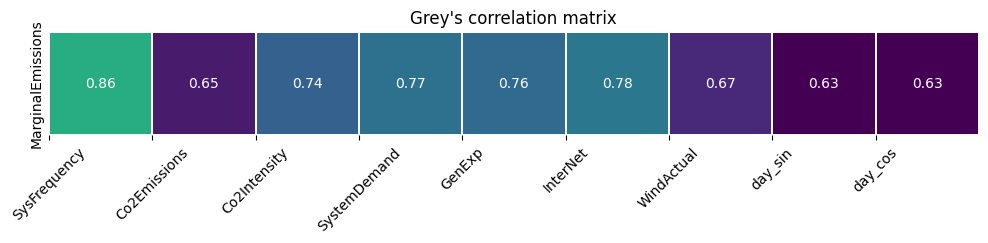

Ranked feature importance


SysFrequency    0.859813
InterNet        0.776019
SystemDemand    0.765004
GenExp          0.755301
Co2Intensity    0.742442
WindActual      0.669707
Co2Emissions    0.654884
day_cos         0.629277
day_sin         0.628644
dtype: float64

['SysFrequency', 'Co2Intensity', 'SystemDemand', 'GenExp', 'InterNet']

In [7]:
grg = grey_relational_grade(features, target)
grg_interpret(grg, features, target)
grg_relevant_features(grg)

,EffectiveTime,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,MarginalEmissions,Fuel_Battery_Storage,...,Fuel_Gas,Fuel_Oil,Fuel_Other_Non_Renewable,Fuel_Other_Renewable,Fuel_Pumped_Storage_Hydro,Fuel_Renewable_Hydro,Fuel_Solar,Fuel_Waste,Fuel_Wind,ImbalanceSettlementPrice
56240,2023-09-28 23:00:00,50.00,812.0,199.0,4080.0,4016.0,273.0,2421.0,311.846154,1.524,...,351.7782,0.00,0.784,10.1122,0.00,73.6730,0.0,39.6130,1033.4126,-5.36
56241,2023-09-28 23:30:00,49.96,792.0,203.0,3909.0,3955.0,0.0,2385.0,1139.666667,0.004,...,333.1159,0.00,0.779,10.0875,0.00,73.5321,0.0,39.1248,1047.3882,-26.01
56242,2023-09-29 00:00:00,49.98,763.0,203.0,3751.0,3802.0,177.0,2324.0,297.983871,0.004,...,321.3548,0.00,0.767,9.8001,0.00,72.5452,0.0,36.3484,1007.0858,-20.92
56243,2023-09-29 00:30:00,50.01,761.0,208.0,3659.0,3572.0,0.0,2125.0,66.664122,0.004,...,309.4047,0.00,0.760,9.7692,0.00,72.0913,0.0,35.6956,987.9791,-26.04
56244,2023-09-29 01:00:00,50.02,753.0,211.0,3573.0,3498.0,0.0,2076.0,211.000000,0.010,...,300.0362,0.00,0.759,9.8542,0.00,72.0466,0.0,35.4494,982.8285,-25.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57711,2023-10-31 21:30:00,50.01,853.0,179.0,4759.0,5016.0,276.0,3195.0,851.882353,0.000,...,403.4862,53.36,0.810,10.3091,5.57,81.2020,0.0,38.4208,1285.0529,25.14
57712,2023-10-31 22:00:00,49.89,860.0,188.0,4565.0,4995.0,-449.0,3114.0,1883.815789,0.517,...,445.7907,36.01,0.826,10.3051,5.97,81.1524,0.0,38.5795,1253.4188,122.25
57713,2023-10-31 22:30:00,50.11,771.0,177.0,4363.0,4780.0,-76.0,3126.0,428.000000,0.000,...,344.6262,1.64,0.825,10.2352,4.64,79.2374,0.0,37.8158,1191.5799,131.83
57714,2023-10-31 23:00:00,50.10,670.0,160.0,4197.0,4397.0,212.0,3003.0,427.838983,0.002,...,331.8480,0.00,0.820,10.2337,0.61,80.3865,0.0,35.1075,1212.8452,17.35


,SysFrequency,Co2Emissions,Co2Intensity,SystemDemand,GenExp,InterNet,WindActual,Fuel_Battery_Storage,Fuel_Biomass_Peat,Fuel_Coal,...,Fuel_Other_Non_Renewable,Fuel_Other_Renewable,Fuel_Pumped_Storage_Hydro,Fuel_Renewable_Hydro,Fuel_Solar,Fuel_Waste,Fuel_Wind,ImbalanceSettlementPrice,day_sin,day_cos
56240,0.478261,0.140381,0.296154,0.343184,0.414940,0.606640,0.596298,0.072478,0.410352,0.061194,...,0.578598,0.808739,0.000000,0.384330,0.0,0.968751,0.622392,0.095497,0.250000,0.933013
56241,0.304348,0.123050,0.311538,0.280015,0.398310,0.453011,0.587294,0.000190,0.377752,0.059822,...,0.574908,0.804522,0.000000,0.382873,0.0,0.944038,0.630928,0.041720,0.308658,0.961940
56242,0.391304,0.097920,0.311538,0.221648,0.356598,0.552617,0.572036,0.000190,0.036031,0.064835,...,0.566052,0.755447,0.000000,0.372664,0.0,0.803493,0.606312,0.054975,0.370590,0.982963
56243,0.521739,0.096187,0.330769,0.187662,0.293893,0.453011,0.522261,0.000190,0.001144,0.076232,...,0.560886,0.750171,0.000000,0.367969,0.0,0.770447,0.594642,0.041642,0.434737,0.995722
56244,0.565217,0.089255,0.342308,0.155892,0.273719,0.453011,0.510005,0.000476,0.001716,0.068760,...,0.560148,0.764685,0.000000,0.367507,0.0,0.757984,0.591496,0.044272,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57711,0.521739,0.175910,0.219231,0.594016,0.687568,0.608329,0.789895,0.000000,0.204175,0.070415,...,0.597786,0.842360,0.038316,0.462210,0.0,0.908401,0.776092,0.174926,0.195619,0.896677
57712,0.000000,0.181976,0.253846,0.522349,0.681843,0.200338,0.769635,0.024587,0.204461,0.070037,...,0.609594,0.841677,0.041068,0.461697,0.0,0.916434,0.756770,0.427824,0.250000,0.933013
57713,0.956522,0.104853,0.211538,0.447728,0.623228,0.410242,0.772636,0.000000,0.179582,0.056134,...,0.608856,0.829742,0.031919,0.441888,0.0,0.877775,0.719000,0.452772,0.308658,0.961940
57714,0.913043,0.017331,0.146154,0.386406,0.518811,0.572313,0.741871,0.000095,0.002288,0.054337,...,0.605166,0.829486,0.004196,0.453775,0.0,0.740677,0.731988,0.154639,0.370590,0.982963


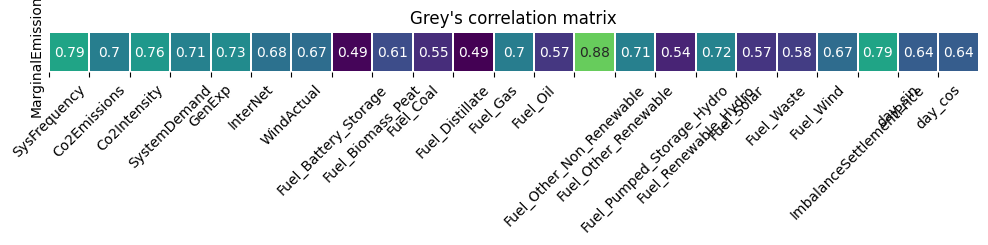

Ranked feature importance


Fuel_Other_Non_Renewable     0.880839
ImbalanceSettlementPrice     0.787349
SysFrequency                 0.785495
Co2Intensity                 0.760529
GenExp                       0.732779
Fuel_Renewable_Hydro         0.715447
SystemDemand                 0.710153
Fuel_Other_Renewable         0.707428
Co2Emissions                 0.703654
Fuel_Gas                     0.702450
InterNet                     0.677379
WindActual                   0.667280
Fuel_Wind                    0.666163
day_sin                      0.636300
day_cos                      0.635868
Fuel_Biomass_Peat            0.605783
Fuel_Waste                   0.578196
Fuel_Oil                     0.568831
Fuel_Solar                   0.565672
Fuel_Coal                    0.552030
Fuel_Pumped_Storage_Hydro    0.536869
Fuel_Battery_Storage         0.492983
Fuel_Distillate              0.486647
dtype: float64

Updated relevant feature set


['SysFrequency',
 'Co2Emissions',
 'Co2Intensity',
 'SystemDemand',
 'GenExp',
 'Fuel_Gas',
 'Fuel_Other_Non_Renewable',
 'Fuel_Other_Renewable',
 'Fuel_Renewable_Hydro',
 'ImbalanceSettlementPrice']

Complete relevant feature set


{'Co2Emissions',
 'Co2Intensity',
 'Fuel_Gas',
 'Fuel_Other_Non_Renewable',
 'Fuel_Other_Renewable',
 'Fuel_Renewable_Hydro',
 'GenExp',
 'ImbalanceSettlementPrice',
 'InterNet',
 'SysFrequency',
 'SystemDemand'}

In [15]:
# Fuel mix
fuel_mix = pd.read_csv(k.PROCESSED_DATA_DIR / 'fuel_mix.csv', index_col=0)
fuel_mix.rename(columns={'StartTime': 'EffectiveTime'}, inplace=True)
fuel_mix['EffectiveTime'] = pd.to_datetime(fuel_mix['EffectiveTime'])

# Pricing data
pricing = pd.read_csv(k.RAW_DATA_DIR / 'semo' / 'price_all.csv', index_col=0)
pricing = pricing[['StartTime', 'NetImbalanceVolume', 'ImbalanceSettlementPrice']]
pricing.rename(columns={'StartTime': 'EffectiveTime'}, inplace=True)
pricing['EffectiveTime'] = pd.to_datetime(pricing['EffectiveTime'])

# Reformat data frame
df = eirgrid.copy().set_index('EffectiveTime')
df = df.resample('30T').asfreq()
df = df.reset_index()

# Join with fuel mix data
df = df.merge(fuel_mix, on='EffectiveTime', how='left')
df = df.dropna()

# Join with pricing data
df = df.merge(pricing.drop(columns='NetImbalanceVolume'), on='EffectiveTime', how='left')
df = df.dropna()
display(df)

# Calculate MEF
target_updated, features_updated = feature_engineer(df)
display(features_updated)
grg_updated = grey_relational_grade(features_updated, target_updated)
grg_interpret(grg_updated, features_updated, target_updated)

print('Updated relevant feature set')
display(grg_relevant_features(grg_updated))
print('Complete relevant feature set')
relevant_features = set(grg_relevant_features(grg_updated) + grg_relevant_features(grg))
relevant_features

In [27]:
# REPORT_TITLE_MAP = {
#     'Fuel_Other_Non_Renewable': 'Non-renewable (other) generation',
#     'ImbalanceSettlementPrice': 'Imbalance settlement price',
#     'SysFrequency': 'System frequency',
#     'Co2Intensity': 'Carbon intensity',
#     'SystemDemand': 'System demand',
#     'Fuel_Renewable_Hydro': 'Renewable (hydro) generation',
#     'Fuel_Other_Renewable': 'Renewable (other) generation',
#     'Co2Emissions': 'Carbon emissions',
#     'Fuel_Gas': 'Non-renewable (gas) generation',
#     'InterNet': 'Net interconnection',
#     'WindActaul': 'Wind generation',
#     'day_sin': 'Sine time encoding',
#     'day_cos': 'Cosine time encoding',
#     'Fuel_Biomass_Peat': 'Biomass/Peat generation',
# }

len(relevant_features)
# grg_updated.mean().sort_values(ascending=False).to_csv('grg.csv')

11

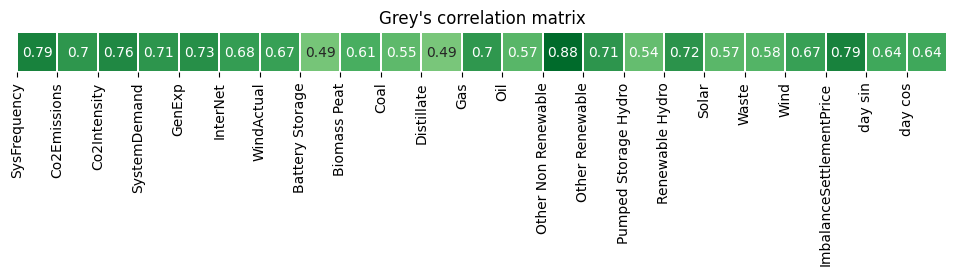

In [65]:
# grg_interpret(grg_updated, features_updated, target_updated)

columns = list(map(lambda x: x.replace('Fuel_', '').replace('_', ' '), features_updated.columns.tolist()))

plt.figure(figsize=(12,7))
sns.heatmap(grg_updated.mean().values.reshape(1,-1), square=True, annot=True,  cbar=False,
            vmax=1.0, vmin=0, linewidths=0.1,cmap=sns.color_palette("Greens", as_cmap=True))
plt.yticks([])
plt.title("Grey's correlation matrix")
plt.xticks(list(range(len(columns))), columns, rotation=90, ha="center")
plt.show()

## Principal Component Analysis

We've identified 8 potential input features, let's try reduce the dimensionality using PCA. PCA can help us do this by creating linear combinations of the input features in a way that maintains the underlying variance in the dataset. 

We can also use this to further identify and isolate the mitigating factors to build out the baseline model

In [10]:
features_df = features_updated[list(relevant_features)]
pca_features = features_df.values
pca_target = target_updated.values
pca = PCA(n_components=0.95)
pca_components = pca.fit_transform(pca_features)
pca_variances = pca.explained_variance_ratio_
principal_df = pd.DataFrame(data=pca_components, columns=[f'PCA_{i}' for i in range(len(pca_variances))])
principal_df['target'] = pca_target
combined_variance = np.sum(pca.explained_variance_ratio_)*100
display(principal_df)
display(pca_variances)
print('Using %d/%d components %.2f%% of the variance is retained' % (len(pca_variances), len(features_df.columns), combined_variance))

# We can recover the most significant feature in each principal component
# This is given to us in the `pca.components_`
n_pcs = pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = features_df.columns
# get the most important feature names
most_important_features = [(i, initial_feature_names[most_important[i]], pca.components_[i][most_important[i]]) for i in range(n_pcs)]

# print('PCA Components')
# display(pca.components_)

print('The most important features from the PCA analysis are')
most_important_cols = list(map(lambda x: x[1], most_important_features))
most_important_features

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,target
0,-0.513391,0.077743,0.082018,-0.002654,0.025631,-0.268418,0.536510
1,-0.586648,0.054531,-0.083364,0.151706,-0.027336,-0.311542,0.551226
2,-0.626523,-0.004802,0.009517,0.096899,0.049907,-0.257093,0.536264
3,-0.656308,-0.029466,-0.090226,-0.014459,0.138112,-0.254761,0.532152
4,-0.674572,-0.061943,-0.095226,-0.059340,0.155569,-0.253393,0.534718
...,...,...,...,...,...,...,...
1465,-0.310306,0.383425,0.139107,-0.067893,-0.073814,-0.273020,0.546110
1466,-0.301340,0.344339,-0.312002,0.303374,-0.441840,-0.096055,0.564454
1467,-0.382448,0.342759,-0.059448,-0.514771,0.039288,0.007548,0.538575
1468,-0.555332,0.278605,0.109233,-0.416361,0.147886,-0.213279,0.538572


array([0.37686003, 0.22694004, 0.17505098, 0.06949431, 0.06278553,
       0.0410152 ])

Using 6/11 components 95.21% of the variance is retained
The most important features from the PCA analysis are


[(0, 'Fuel_Gas', 0.611098808484488),
 (1, 'SystemDemand', 0.6089134468128158),
 (2, 'InterNet', 0.968490638072074),
 (3, 'SysFrequency', -0.8449733220625393),
 (4, 'Fuel_Other_Renewable', -0.641580906479068),
 (5, 'ImbalanceSettlementPrice', 0.8069274016071629)]

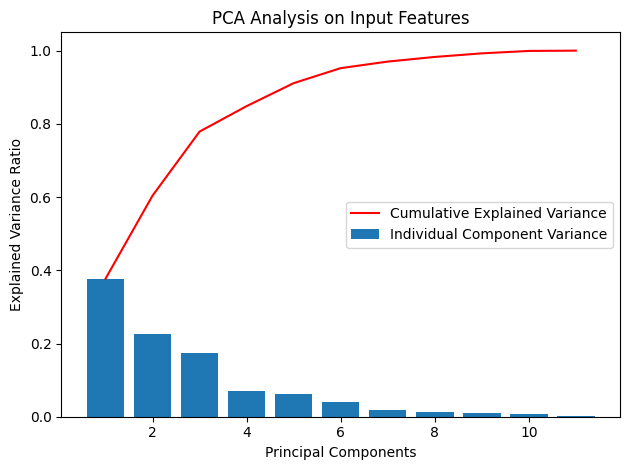

In [11]:
pca = PCA(n_components=0.9999)
pca_components = pca.fit_transform(pca_features)
pca_variances = pca.explained_variance_ratio_
plt.figure()
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.bar(components, pca.explained_variance_ratio_, align='center', label='Individual Component Variance')
plt.plot(components, np.cumsum(pca.explained_variance_ratio_), label='Cumulative Explained Variance', color='red')
plt.title('PCA Analysis on Input Features')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Training Data

Given the input features have been identified we can export our training data for later use. 


#### Feature Selection
We're going to use 5 input features to start with
1. ImbalanceSettlmentPrice $p_t$
2. InterNet $k_t$
3. SysFrequency $q_t$
4. SystemDemand $d_t$
5. WindActual $\omega_t$
6. Fuel_Mixed $m_t$

Based on the combined Gray's analysis and dimensionality reduction using PCA. Interestingly enough, it seems that the time of the day (`day_cos` `day_sin` information) is not relevant to the prediction. Probabably because the underlying system information contributes more to the MEF than the time of day.


In [66]:
scaler = MinMaxScaler()
training_data = df.copy()
training_data = training_data.reindex(columns=most_important_cols + ['MarginalEmissions'])
training_data[most_important_cols] = scaler.fit_transform(training_data[most_important_cols].values)
training_data.to_csv(k.PROCESSED_DATA_DIR / 'features_target.csv')
training_data

,Fuel_Gas,SystemDemand,InterNet,SysFrequency,Fuel_Other_Renewable,ImbalanceSettlementPrice,MarginalEmissions
56240,0.106146,0.343184,0.606640,0.478261,0.808739,0.095497,311.846154
56241,0.089933,0.280015,0.453011,0.304348,0.804522,0.041720,1139.666667
56242,0.079715,0.221648,0.552617,0.391304,0.755447,0.054975,297.983871
56243,0.069333,0.187662,0.453011,0.521739,0.750171,0.041642,66.664122
56244,0.061194,0.155892,0.453011,0.565217,0.764685,0.044272,211.000000
...,...,...,...,...,...,...,...
57711,0.151068,0.594016,0.608329,0.521739,0.842360,0.174926,851.882353
57712,0.187820,0.522349,0.200338,0.000000,0.841677,0.427824,1883.815789
57713,0.099933,0.447728,0.410242,0.956522,0.829742,0.452772,428.000000
57714,0.088831,0.386406,0.572313,0.913043,0.829486,0.154639,427.838983


## Baseline Model
This is obviously going to be terrible - but it's the simplest model we can create.

The goal is to design a _linear model_ that takes the carbon intensity and generation at time step t to predict the marginal emissions factor at the next. This is a MLP ANN without a hidden layer
$$
p_t w_3 + k_t w_4 + q_t w_5 + d_t w_6 + \omega_t w_7 = ME_{t+1}
$$



In [13]:
# TODO develop baseline model